# Laboratory 4: Getting started with Pytorch

In this laboratory we will begin working with Pytorch to implement and train complex, nonlinear models for supervised learning problems. You will notice many similarities between Numpy and Pytorch -- this is deliberate, but it can cause some confusion and for many things we will have to convert back and forth between Numpy arrays and Pytorch tensors.

## Part 0: First steps

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [2]:
# We're still going to need numpy and matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import math

# Verify that pytorch is working.
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

foo = torch.randn((3, 3))
print(foo)

Using mps device
tensor([[ 1.4498,  0.5903,  0.4048],
        [-0.0232, -1.1987,  0.6948],
        [-0.9048, -0.0978, -1.7765]])


## Part 1: Dataset preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use.

In [3]:
# Import necessary libraries
from torchvision.datasets import MNIST
import torchvision
import matplotlib.pyplot as plt

# Download and load the MNIST dataset.
# MNIST dataset contains handwritten digits (0 through 9) as 28x28 images.
# Each image is accompanied by its corresponding label indicating the digit.
ds_train = MNIST(root='./data', download=True, train=True)
ds_test  = MNIST(root='./data', download=True, train=False)

### Exercise 1.1: Exploratory data analysis

Spend some time inspecting the `ds_train` and `ds_test` data structures in order to get a feel for the data. What is the format? How big are the images? How many are there? What about the range of pixel values? Where are the labels for images? 

Remember that one of the best ways to explore is to *visualize*.

Number of training examples: 60000
Number of test examples: 10000
Image size: (28, 28)


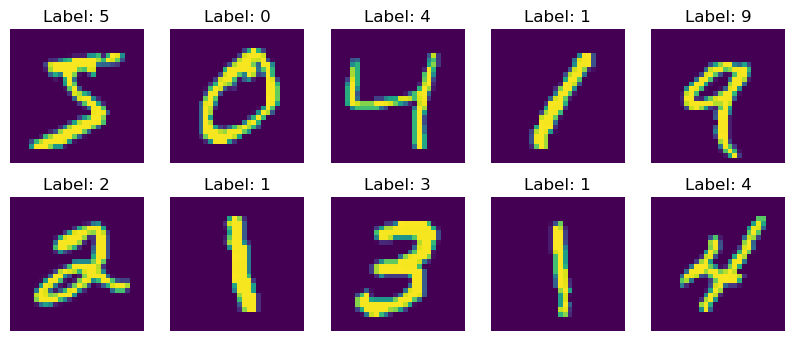

In [4]:


# Print some information about the dataset
print("Number of training examples:", len(ds_train))
print("Number of test examples:", len(ds_test))
print("Image size:", ds_train[0][0].size)

# Plot a few sample images from the training set
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        image, label = ds_train[i * 5 + j]
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.show()


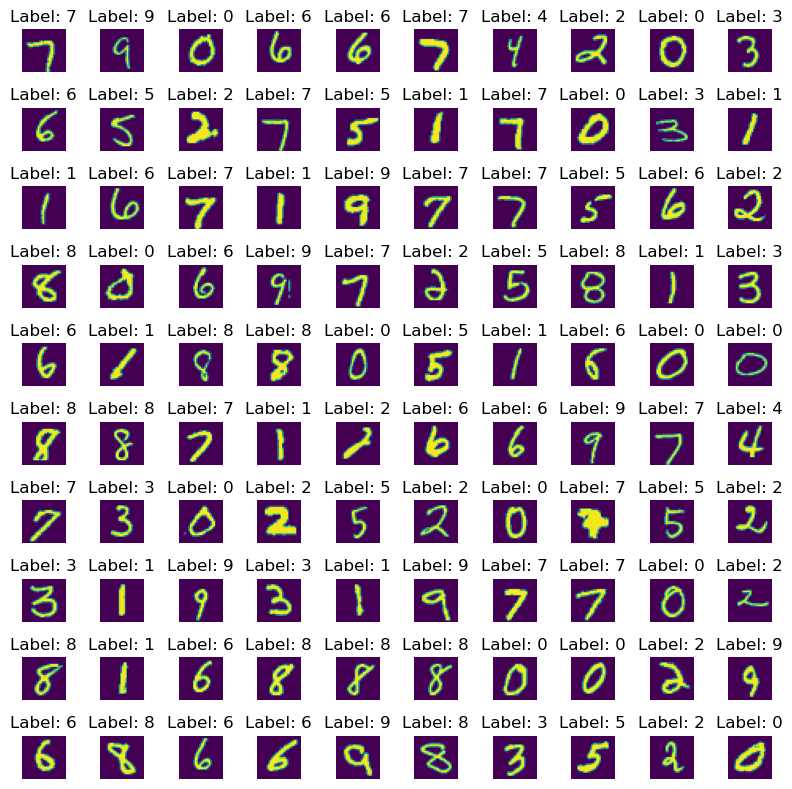

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Create a random permutation of indices for the first 100 images in the training set
random_indices = np.random.permutation(ds_train.data.shape[0])[:100]

plt.figure(figsize=(8, 8))

# Visualize the first 100 randomly selected images from the training set
for i, index in enumerate(random_indices):
    # Subplot organization: 10 rows, 10 columns, i+1 refers to the current subplot index
    plt.subplot(10, 10, i+1)
    
    # Display the image in grayscale
    plt.imshow(ds_train.data[index])
    
    # Set the title with the corresponding label
    plt.title(f"Label: {ds_train.targets[index]}")
    
    # Turn off axis ticks for cleaner visualization
    plt.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the visualization
plt.show()


### Exercise 1.2: Dataset conversion and normalization

+ **Datatype Conversion**:
The first thing we need to do is convert all data tensors to `torch.float32` -- this is fundamental as it is extremely inconvenient to work with `uint8` data. Using 32-bit floating point numbers is a compromise between precision and space efficiency.
The `torch.Tensor` class has a very useful method `to()` for performing datatype and device (e.g. to GPU) conversions. Check out the [documentation here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to).

+ **Normalization**:
Next, we need to correct the inconvenient range of [0, 255] for the pixel values. You should *subtract* the mean intensity value and divide by the standard deviation in order to *standardize* our data. **Important**: Think *very carefully* about *which* split you should use to compute the pixel statistics for standardization.

+ **Reshaping**: Is the data in an appropriate format (i.e. shape) for the training the models we know? Think about whether (and how) to fix this if needed. 

**What to do**: In the cell below you should perform this sequence preprocessing operations on the `ds_train.data` and `ds_test.data` tensors. 

In [6]:
# Datatype Conversion
Xs_train = ds_train.data.to(torch.float32).flatten(-2)
Xs_test = ds_test.data.to(torch.float32).flatten(-2)

# Normalization
mean = Xs_train.mean()
std = Xs_train.std()
Xs_train -= mean
Xs_train /= std

# Apply the same normalization to the test data
Xs_test -= mean
Xs_test /= std

# Extract the labels
ys_train = ds_train.targets
ys_test = ds_test.targets

# Display the resulting labels
print("Training labels:", ys_train)
print("Test labels:", ys_test)


Training labels: tensor([5, 0, 4,  ..., 5, 6, 8])
Test labels: tensor([7, 2, 1,  ..., 4, 5, 6])


### Exercise 1.3: Subsampling the MNIST dataset.

MNIST is kind of big, and thus inconvenient to work with unless using the GPU. For this laboratory we will use a smaller subset of the dataset for training to keep memory and computation times low.

Modify `ds.train` to use only a subset of, say, 10000 images sampled from the original data. Make sure to select the correct corresponding targets.


In [7]:
# Set a random seed for reproducibility
torch.manual_seed(2345)

# Number of samples to keep
num_train = 10000

# Randomly shuffle the indices and select a subset
I = torch.randperm(Xs_train.shape[0])[:num_train]

# Subsample the data and corresponding targets
Xs_train_small = Xs_train[I]
ys_train_small = ys_train[I]

# Display the shape of the subsampled data
print("Subsampled Training Data Shape:", Xs_train_small.shape)
print("Subsampled Training Targets Shape:", ys_train_small.shape)


Subsampled Training Data Shape: torch.Size([10000, 784])
Subsampled Training Targets Shape: torch.Size([10000])


## Establishing a stable baseline

In this exercise you will establish a reliable baseline using a classical approach. This is an important step in our methodology in order to judge whether our Deep MLP is performing well or not.

### Exercise 2.1: Establish the stable baseline

Train and test your stable baseline to estimate the best achievable accuracy using classical models.

**Tip**: Don't do any extensive cross-validation of your baseline (for now). Just fit a simple model (e.g. a linear SVM) and record the accuracy.



In [8]:
"""
from sklearn.svm import SVC

Xs_train_small.reshape(10000, 28*28)
Xs_train_small.flatten(-2).shape

svc = SVC()
svc.fit(Xs_train_small, ys_train_small)
(svc.predict(Xs_test) == ys_test.numpy()).mean()
from sklearn.metrics import classification_report

print(classification_report(svc.predict(Xs_test), ys_test))"""

'\nfrom sklearn.svm import SVC\n\nXs_train_small.reshape(10000, 28*28)\nXs_train_small.flatten(-2).shape\n\nsvc = SVC()\nsvc.fit(Xs_train_small, ys_train_small)\n(svc.predict(Xs_test) == ys_test.numpy()).mean()\nfrom sklearn.metrics import classification_report\n\nprint(classification_report(svc.predict(Xs_test), ys_test))'

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Reshape the data if needed (SVC expects 2D input)
Xs_train_2d = Xs_train_small.reshape(Xs_train_small.shape[0], -1)
Xs_test_2d = Xs_test.reshape(Xs_test.shape[0], -1)

# Instantiate the Support Vector Classifier (SVC)
svc = SVC()

# Fit the model on the training data
svc.fit(Xs_train_2d, ys_train_small)

# Predict the labels for the test data
predictions = svc.predict(Xs_test)

# Calculate accuracy
accuracy = accuracy_score(ys_test.numpy(), predictions)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(predictions, ys_test))


Accuracy: 0.9611
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.99      0.98      0.98      1146
           2       0.96      0.96      0.96      1033
           3       0.95      0.95      0.95      1009
           4       0.97      0.96      0.96       992
           5       0.96      0.97      0.96       882
           6       0.97      0.96      0.97       966
           7       0.94      0.96      0.95      1013
           8       0.95      0.96      0.95       963
           9       0.94      0.95      0.95       996

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


## Part 3: Training some deep models (finally)

Now we will finally train some deep models (Multilayer Perceptrons, to be precise). Since the dataset is a bit too large to use batch gradient descent, we will first need to setup a `torch.utils.data.DataLoader` for our training data. A `DataLoader` breaks the dataset up into a sequence of *batches* that will be used for training. In order to use this, we will first have to use `torch.utils.data.TensorDataset` on `ds_train.data` and `ds_train.targets` to make a new torch `dataset` for use in the dataloader. 

### Exercise 3.1: Creating the DataLoader

Create a `DataLoader` for `ds_train` use a `batch_size` of about 16 or 32 to start. After you have your `DataLoader` experiment with is using `next(iter(dl_train))` to see what it returns. The pytorch `DataLoader` is a Python iterator.

**EXTREMELY IMPORTANT**: Make sure you use `shuffle=True` in the constructor of your dataloader.

In [10]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

# Convert labels to long tensor to match the expected data type for classification
ys_train_small = ys_train_small.long()

# Create a DataLoader for training data
dl_train = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=batch_size, shuffle=True)

# Test the DataLoader using next(iter(dl_train))
batch = next(iter(dl_train))
print("Batch size:", len(batch))
print("Features shape:", batch[0].shape)
print("Labels shape:", batch[1].shape)


Batch size: 2
Features shape: torch.Size([32, 784])
Labels shape: torch.Size([32])


### Some support code (NOT an exercise).

Here is some support code that you can use to train a model for a **single** epoch. The function returns the mean loss over all iterations. You will use it in the next exercise to train and monitor training.

In [11]:
# Train a model for a single epoch. You should pass it a model, a dataloader,
# and an optimizer. Returns the mean loss over the entire epoch.
def train_epoch(model, dl, optimizer):
    model.train() # sets the model to training mode
    losses = [] #list to collect the per-iterration losses.
    
    #iterate over the data loader
    for (xs, ys) in dl: 
        optimizer.zero_grad() #zero out the gradients at each parameters
        output = model(xs) #forward pass of batch through the model
        
        #compute the loss(negative log likelihood)
        loss = torch.nn.functional.nll_loss(output, ys)
        
        #compute the gradients at al parameters
        loss.backward()
        
        #perform step of gradient descent
        optimizer.step()
        
        #record the loss
        losses.append(loss.item())
        
    #leave model in evaluation mode and return loss
    model.eval()
    return np.mean(losses)

### Exercise 3.2: Defining a 1-layer neural network

Define a simple model that uses a **single** `torch.nn.Linear` layer followed by a `torch.nn.Softmax` to predict  the output probabilities for the ten classes.

In [12]:
# Define a fresh model
model = torch.nn.Sequential(
    torch.nn.Linear(784, 10),
    torch.nn.LogSoftmax(dim=1)  # Specify dim=1 to apply LogSoftmax along the second dimension
)


### Exercise 3.2: Training our model

Instantiate a `torch.optim.SGD` optimizer using `model.parameters()` and the learning rate (**tip**: make the learning rate variable you can easily change). Then run `train_epoch` for a set number of epochs (e.g. 100, make this a variable too). Is your model learning? How can you tell?

Epoch 10/100, Training Loss: 0.4291301100684431
Epoch 20/100, Training Loss: 0.36398974570412984
Epoch 30/100, Training Loss: 0.3339062436653402
Epoch 40/100, Training Loss: 0.31564480147232266
Epoch 50/100, Training Loss: 0.3023919961370599
Epoch 60/100, Training Loss: 0.29214185556045735
Epoch 70/100, Training Loss: 0.2837960372527186
Epoch 80/100, Training Loss: 0.27709820747565916
Epoch 90/100, Training Loss: 0.2707690958754894
Epoch 100/100, Training Loss: 0.2656601166929871


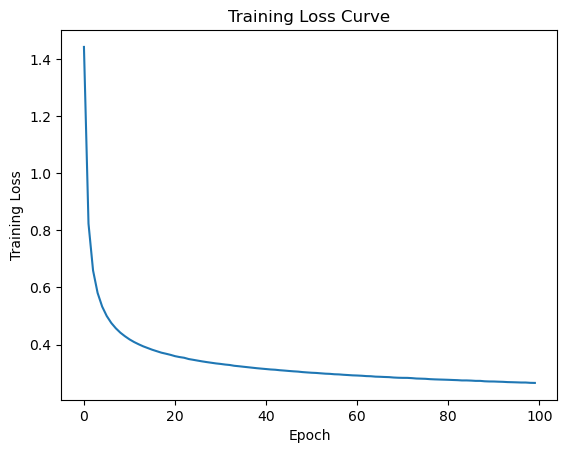

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.96      0.97      0.97      1135
           2       0.92      0.87      0.90      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.93      0.92       982
           5       0.87      0.86      0.87       892
           6       0.92      0.93      0.93       958
           7       0.91      0.92      0.91      1028
           8       0.86      0.86      0.86       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000


In [13]:
# Set the learning rate and number of epochs
learning_rate = 0.001
num_epochs = 100

# Instantiate SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store training loss over epochs
train_loss_curve = []

# Training loop
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss = train_epoch(model, dl_train, optimizer)
    
    # Append the training loss to the curve
    train_loss_curve.append(train_loss)
    
    # Print training progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss}")

# Plot the training loss curve
plt.plot(train_loss_curve)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

# Evaluate the model on the test set
predictions = torch.argmax(model(Xs_test_2d), dim=1)     ######!!!!
print("Classification Report:")
print(classification_report(ys_test, predictions))


### Exercise 3.3: Evaluating our model

Write some code to plot the loss curve for your training run and evaluate the performance of your model on the test data. Play with the hyperparameters (e.g. learning rate) to try to get the best performance on the test set. Can you beat the stable baseline?

**DONE upper**

Trying to beat the baseline with some hyperparameter tuning.

In [14]:
# Set hyperparameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
num_epochs = 100

# Lists to store training loss and accuracy over epochs
train_loss_curves = []
train_accuracy_curves = []

# Perform grid search
best_accuracy = 0.0
best_hyperparameters = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Instantiate SGD optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        # Create a DataLoader for training data
        dl_train = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=batch_size, shuffle=True)

        # Training loop
        train_loss_curve = []
        train_accuracy_curve = []

        for epoch in range(num_epochs):
            # Train the model for one epoch
            train_loss = train_epoch(model, dl_train, optimizer)
            train_loss_curve.append(train_loss)

            # Evaluate training accuracy
            predictions = torch.argmax(model(Xs_train_2d), dim=1)
            accuracy = torch.sum(predictions == ys_train_small).item() / len(ys_train_small)
            train_accuracy_curve.append(accuracy)

        # Store the training loss and accuracy curves for this configuration
        train_loss_curves.append((lr, batch_size, train_loss_curve[-1]))
        train_accuracy_curves.append((lr, batch_size, train_accuracy_curve[-1]))

        # Update best hyperparameters if accuracy is improved
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}

# Print the results
print("Training Loss and Accuracy for Different Hyperparameter Configurations:")
for lr, batch_size, final_loss in train_loss_curves:
    print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Final Training Loss: {final_loss}")

print("\nBest Hyperparameters Based on Training Accuracy:")
print(f"Learning Rate: {best_hyperparameters['learning_rate']}, Batch Size: {best_hyperparameters['batch_size']}, Best Training Accuracy: {best_accuracy}")

# Evaluate the model on the test set using the best hyperparameters
best_lr = best_hyperparameters['learning_rate']
best_batch_size = best_hyperparameters['batch_size']
best_optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
best_dl_train = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=best_batch_size, shuffle=True)
for epoch in range(num_epochs):
    train_epoch(model, best_dl_train, best_optimizer)

# Evaluate on the test set
predictions_test = torch.argmax(model(Xs_test_2d), dim=1)
accuracy_test = torch.sum(predictions_test == ys_test).item() / len(ys_test)

print("\nFinal Evaluation on Test Set:")
print(f"Test Accuracy with Best Hyperparameters: {accuracy_test}")

Training Loss and Accuracy for Different Hyperparameter Configurations:
Learning Rate: 0.001, Batch Size: 16, Final Training Loss: 0.21458114297538997
Learning Rate: 0.001, Batch Size: 32, Final Training Loss: 0.20065370584115053
Learning Rate: 0.001, Batch Size: 64, Final Training Loss: 0.19498349517394023
Learning Rate: 0.01, Batch Size: 16, Final Training Loss: 0.13048202322497965
Learning Rate: 0.01, Batch Size: 32, Final Training Loss: 0.11014064750113427
Learning Rate: 0.01, Batch Size: 64, Final Training Loss: 0.10266132563779688
Learning Rate: 0.1, Batch Size: 16, Final Training Loss: 0.08175946703541268
Learning Rate: 0.1, Batch Size: 32, Final Training Loss: 0.027897308202878463
Learning Rate: 0.1, Batch Size: 64, Final Training Loss: 0.02157484051907898

Best Hyperparameters Based on Training Accuracy:
Learning Rate: 0.1, Batch Size: 32, Best Training Accuracy: 0.9978

Final Evaluation on Test Set:
Test Accuracy with Best Hyperparameters: 0.8755


Results indicate that the model achieved super good training accuracy 99% with the hyperparameters tuning. However, the test accuracy is lower at 87%. A perfect training accuracy and a lower test accuracy may suggest overfitting, where the model has memorized the training data but struggles to generalize to new, unseen data.

## Going Deeper

Now we will go (at least one layer) deeper to see if we can significantly improve on the baseline.

### Exercise 3.4: A 2-layer MLP
Define a new model with one hidden layer. Use the code you wrote above to train and evaluate this new model. Can you beat the baseline? You might need to train in two stages using different learning rates.

**Things to think about**:

+ It might be hard to beat (or even equal) the baseline with deeper networks. Why?
+ Is there something else we should be monitoring while training, especially for deep networks?

In [15]:
import torch.nn.functional as F

# Define a 2-layer MLP
class MLP2Layer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP2Layer, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

# Instantiate the model
input_size = 784
hidden_size = 128
output_size = 10
model_2layer = MLP2Layer(input_size, hidden_size, output_size)

# Set hyperparameters
learning_rate_stage1 = 0.01
learning_rate_stage2 = 0.001
batch_size = 32
num_epochs_stage1 = 50
num_epochs_stage2 = 50

# Instantiate SGD optimizer for stage 1
optimizer_stage1 = torch.optim.SGD(model_2layer.parameters(), lr=learning_rate_stage1)

# Create a DataLoader for training data
dl_train_2layer = DataLoader(TensorDataset(Xs_train_2d, ys_train_small), batch_size=batch_size, shuffle=True)

# Training loop for stage 1
for epoch in range(num_epochs_stage1):
    train_epoch(model_2layer, dl_train_2layer, optimizer_stage1)

# Instantiate SGD optimizer for stage 2
optimizer_stage2 = torch.optim.SGD(model_2layer.parameters(), lr=learning_rate_stage2)

# Training loop for stage 2
for epoch in range(num_epochs_stage2):
    train_epoch(model_2layer, dl_train_2layer, optimizer_stage2)

# Evaluate on the test set
predictions_test_2layer = torch.argmax(model_2layer(Xs_test_2d), dim=1)
accuracy_test_2layer = torch.sum(predictions_test_2layer == ys_test).item() / len(ys_test)

print("Test Accuracy with 2-layer MLP:", accuracy_test_2layer)


Test Accuracy with 2-layer MLP: 0.9554
